# MSDM5003 Homework 6
__name:__ LIU Jingting

__ID:__ 21128685

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 1. Autocorrelation of the Absolute Return of S&P500

[*********************100%***********************]  1 of 1 completed


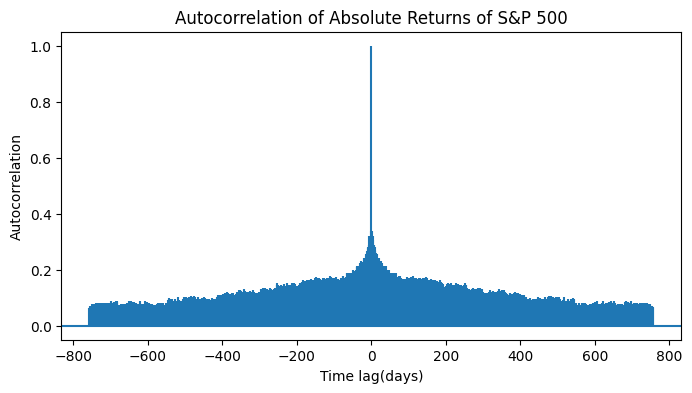

In [2]:
# a.Download the dataset
start_date = '1927-12-30'
end_date = '2024-11-01'
data = yf.download('^GSPC', start=start_date, end=end_date)

# b.Clean the data using the Pandas command “dropna()”.
data_cleaned = data.dropna()

# c.Extract the time series of the absolute returns from the column ‘Adj Close’.
data_cleaned['Absolute Returns'] = data_cleaned['Adj Close'].pct_change().abs()
absolute_returns = data_cleaned['Absolute Returns']

# d.Subtract the time series by its average.
mean_return = data_cleaned['Absolute Returns'].mean()
data_cleaned['Centered Returns'] = data_cleaned['Absolute Returns'] - mean_return

# e.Plot the autocorrelation of the absolute return using the command “plt.acorr()”.
plt.figure(figsize=(8,4))
plt.acorr(data_cleaned['Centered Returns'].dropna(), maxlags = 3 * 252)
plt.title('Autocorrelation of Absolute Returns of S&P 500')
plt.xlabel('Time lag(days)')
plt.ylabel('Autocorrelation')
plt.show()

In [3]:
returns = data_cleaned['Centered Returns'].dropna().to_numpy()
suggested_max_lag = 3 * 252  # Suggesting 3 years of trading days

## 2. Power Spectral Density of NYSE

In [4]:
# a.Prepare the non-negative branch of the autocorrelation obtained from Question 1.
autocorrelation = np.correlate(returns, returns, mode='full') 
truncated_autocorr = autocorrelation[len(autocorrelation) // 2 : len(autocorrelation) // 2 + suggested_max_lag + 1]
np.all(truncated_autocorr >= 0)   # test whether all the correlation values are non-negative

True

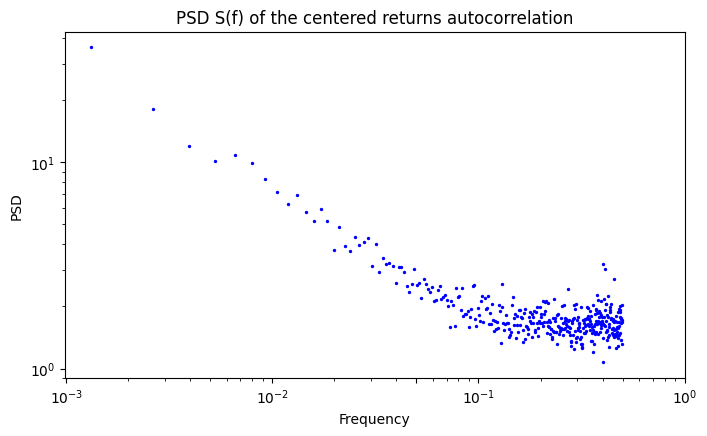

In [5]:
# b.Plot the power spectral density  of the above autocorrelation function using logarithmic scales for both axes.
amp = np.abs(np.fft.fft(truncated_autocorr))
psd = amp
freqs = np.fft.fftfreq(len(truncated_autocorr), d=1)
positive_freqs = freqs[freqs >= 0]
positive_psd = psd[freqs >= 0]

plt.figure(figsize=(8, 4.5))
# plt.loglog(positive_freqs[1:], positive_psd[1:])  
plt.scatter(positive_freqs[1:], positive_psd[1:], color='blue', s=2)  
plt.xscale('log')
plt.yscale('log')
plt.title('PSD S(f) of the centered returns autocorrelation')
plt.xticks([1e-3, 1e-2, 5e-2, 1e-1, 1])
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.show()

Beta at high frequency: -0.0031467528422651947
Beta at low frequency: 0.5682200651427479


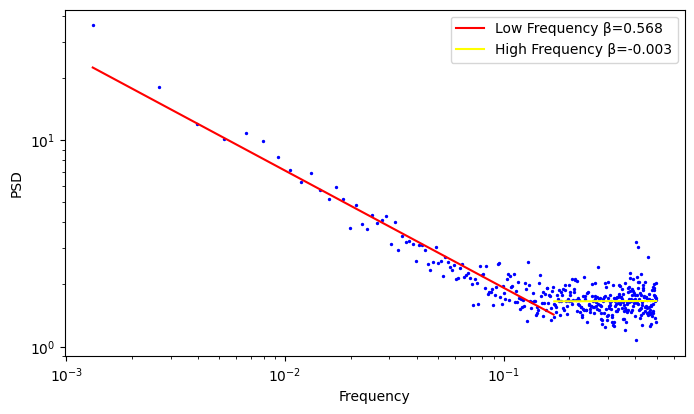

In [12]:
# c. Obtain the values of the exponent 
plt.figure(figsize=(8, 4.5))
plt.scatter(positive_freqs[1:], positive_psd[1:], color='blue', s=2)  
plt.xscale('log')
plt.yscale('log')
# plt.loglog(positive_freqs[1:], positive_psd[1:], color='blue')  
crossover_point = 0.17

low_freqs = positive_freqs[(positive_freqs > 0) & (positive_freqs <= crossover_point)]
low_psd = positive_psd[(positive_freqs > 0) & (positive_freqs <= crossover_point)]
log_low_freqs = np.log(low_freqs)  # take logarithm
log_low_psd = np.log(low_psd)

# regression fitting
# low frequency
low_res = LinearRegression().fit(log_low_freqs.reshape(-1, 1), log_low_psd)
beta1, intercept1 = low_res.coef_[0], low_res.intercept_
 
x = np.linspace(min(log_low_freqs), max(log_low_freqs), 100)
y = intercept1 + beta1 * x
plt.plot(np.exp(x), np.exp(y), color='red', label=f'Low Frequency β={-beta1:.3f}')

# high frequency
high_freqs = positive_freqs[positive_freqs > crossover_point]
high_psd = positive_psd[positive_freqs > crossover_point]

log_high_freqs = np.log(high_freqs)
log_high_psd = np.log(high_psd)

high_res = LinearRegression().fit(log_high_freqs.reshape(-1, 1), log_high_psd)
beta2, intercept2 = high_res.coef_[0], high_res.intercept_
print(f'Beta at high frequency: {-beta2}')
print(f'Beta at low frequency: {-beta1}')

x = np.linspace(min(log_high_freqs), max(log_high_freqs), 100)
y = intercept2 + beta2 * x
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.plot(np.exp(x), np.exp(y), color='yellow', label=f'High Frequency β={-beta2:.3f}')
plt.legend()
plt.show()

Fitting result of linear regression suggests that $\beta$ at low frequency is approximately 0.568, and at high frequency the exponent almost dimishes. I also tried with a maximum lag of 5, 10, and 50 years, their results at low frequency turned out to be the same, suggesting data at high frequency might be too noisy. 

## 3.Detrended Fluctuation Analysis of NYSE

In [7]:
# a.Generate the series of cumulative sum.
# data_cleaned['Cumulative Sum'] = data_cleaned['Centered Returns'].cumsum()
cum_sum = np.cumsum(returns)
cum_sum

array([-1.96884498e-03, -7.34792200e-03, -5.38561865e-03, ...,
       -6.65217318e-03, -1.09833201e-02,  1.72050568e-12])

In [8]:
# b&c.The Sliding Window Method and RMSE
min_points = 7  
# select the exponents x that increase from 0.1int(10log10 7) to 0.1int(10log10 Tmax) in steps of 0.1
T_max = suggested_max_lag
x_min = 0.1 * int(10 * np.log10(min_points))
x_max = 0.1 * int(10 * np.log10(T_max))
x_vals = np.arange(x_min, x_max + 0.1, 0.1)
taus = np.unique(np.int64(10**x_vals))
taus = taus[(taus >= min_points) & (taus <= T_max)]
# xs = np.arange(np.log10(min_points), np.log10(suggested_max_lag) + 0.1, 0.1)
# taus = np.unique(np.round(10 ** xs).astype(int))

eps_vals, tau_vals = list(), list()
T = len(cum_sum)

# computing RMSE as F(τ)
for tau in taus:
    rmse_vals = []
    x = np.arange(tau)
    x_mean = (tau - 1) / 2
    x2_mean = (tau - 1) * (2 * tau - 1) / 6
    denominator = x2_mean - x_mean**2
    if denominator < 1e-7:
        continue
    for t0 in range(T - tau + 1):
        y = cum_sum[t0 : t0 + tau]
        y_mean = np.mean(y)
        y2_mean = np.mean(y**2)
        xy_mean = np.dot(x, y) / tau
        numerator = (xy_mean - x_mean * y_mean)**2
        
        eps = (y2_mean - y_mean**2 - numerator/denominator)**0.5
        rmse_vals.append(eps)
    
#     x = np.arange(1, tau + 1)
#     x_mean = np.mean(x)
#     x2_mean = np.mean(x**2)
#     denominator = x2_mean - x_mean ** 2
#     if denominator < 1e-7:
#         continue
#     num_windows = N - tau  # number of sliding windows
#     rmse_vals = []
#     for t in range(1, num_windows + 1):
#         y = data_cleaned['Cumulative Sum'][t:t + tau] 
#         nominator = (np.dot(x, y) - x_mean * np.mean(y)) ** 2
#         rmse = np.sqrt(np.abs(np.mean(y**2) - (np.mean(y))**2 - nominator / denominator))
#         rmse_vals.append(rmse)
    eps_vals.append(np.mean(rmse_vals))
    
tau_vals = np.array(taus)
eps_vals = np.array(eps_vals)

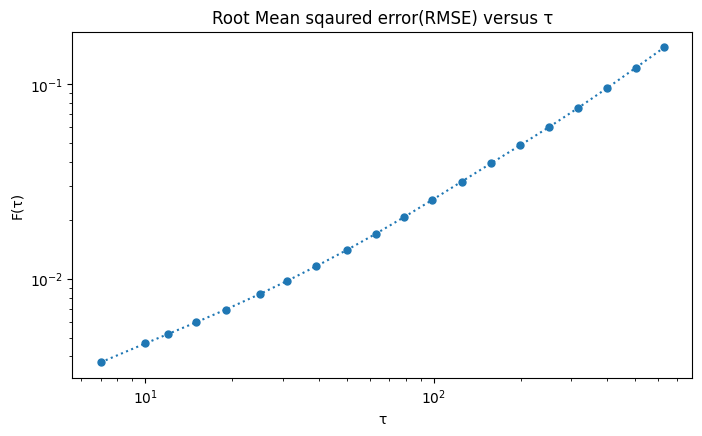

In [9]:
# visualizing result in log-log plot
plt.figure(figsize=(8, 4.5))
plt.loglog(tau_vals, eps_vals, marker='o', linestyle=':', markersize=5)
plt.title('Root Mean sqaured error(RMSE) versus τ')
plt.xlabel('τ')
plt.ylabel('F(τ)')
plt.show()

alpha of long-time: 1.0413086752246374
Beta at high frequency: -0.0031467528422651947
alpha of short-time: 0.7807524617975609
Beta at low frequency: 0.5682200651427479


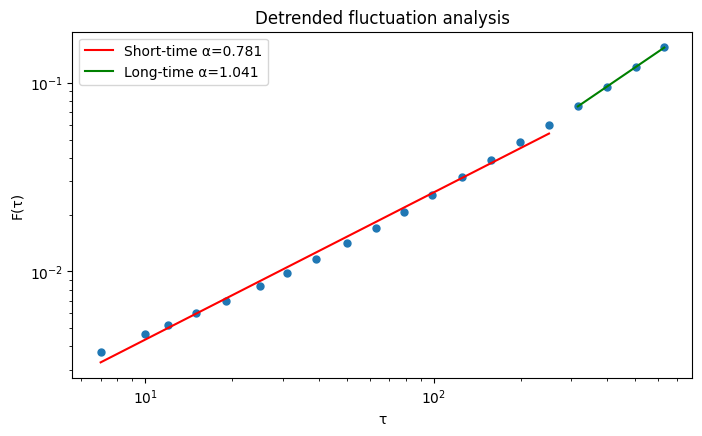

In [13]:
# d&e. Compute alpha for different regimes using linear regression
log_tau = np.log10(tau_vals)
log_F = np.log10(eps_vals)

crossover_idx = len(tau_vals) // 2 + 6  

res_short = LinearRegression().fit(log_tau[:crossover_idx].reshape(-1, 1), log_F[:crossover_idx])
res_long = LinearRegression().fit(log_tau[crossover_idx:].reshape(-1, 1), log_F[crossover_idx:])
alpha_short = res_short.coef_[0]
alpha_long = res_long.coef_[0]

print(f"alpha of long-time: {alpha_long}")
print(f'Beta at high frequency: {-beta2}')
print(f"alpha of short-time: {alpha_short}")
print(f'Beta at low frequency: {-beta1}')

plt.figure(figsize=(8, 4.5))
plt.loglog(tau_vals, eps_vals, 'o', markersize=5)

# short time fit
tau_short = tau_vals[:crossover_idx]
F_short = eps_vals[:crossover_idx]
fit_short = 10**(alpha_short * np.log10(tau_short) + np.mean(np.log10(F_short) - alpha_short * np.log10(tau_short)))
    
# long time fit
tau_long = tau_vals[crossover_idx:]
F_long = eps_vals[crossover_idx:]
fit_long = 10**(alpha_long * np.log10(tau_long) + np.mean(np.log10(F_long) - alpha_long * np.log10(tau_long)))
    
plt.loglog(tau_short, fit_short, 'r-', label=f'Short-time α={alpha_short:.3f}')
plt.loglog(tau_long, fit_long, 'g-', label=f'Long-time α={alpha_long:.3f}')
    
plt.xlabel('τ')
plt.ylabel('F(τ)')
plt.title('Detrended fluctuation analysis')
plt.legend()
plt.show()

# beta = 2alpha - 1

Looking at short-time $\alpha$ = 0.781 and low frequency $\beta$ = 0.568, we can find that $2\alpha -1 = 0.562 \approx \beta$, suggesting relation $\beta = 2\alpha -1$ holds. 